In [1]:
import tensorflow as tf
import pandas as pd
import sklearn

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-24 11:12:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-24 11:12:33 (82.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

# Preprocessing data

In [4]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-01-24 11:12:34--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2024-01-24 11:12:34 (121 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Splitting into training and validation sets

In [6]:
"""
Since the test set has no labels and we need a way to evalaute our trained
models, we'll split off some of the training data and create a validation set.

When our model trains, it'll only see data from the training set and we can see
how it performs on unseen data using the validation set.

We'll convert our splits from pandas Series datatypes to lists of strings (
for the text) and lists of ints (for the labels) for ease of use later.

To split our training dataset and create a validation dataset, we'll use
Scikit-Learn's train_test_split() method and dedicate 10% of the training samples
to the validation set.
"""
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df["text"].to_numpy(),
                                                                            train_df["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)


(6851, 6851, 762, 762)

### Creating an embedding

In [7]:
# We must first convert our text into numbers before creating an embedding layer

max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

# We create a TextVectorization object
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

text_vectorizer.adapt(train_sentences)

In [8]:
embedding_layer = tf.keras.layers.Embedding(input_dim=max_vocab_length, # set input shape
                                            output_dim=128, # set size of embedding vector
                                            embeddings_initializer="uniform", # default, intialize randomly
                                            input_length=max_length, # how long is each input
                                            name="embedding_1")

# Exercise 1: Rebuild, compile and train model_1, model_2 and model_5 using the Keras Sequential API instead of the Functional API.

## Model 1: Multilayer Perceptron (Feed-forward network)

In [9]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, ), dtype='string'),
    text_vectorizer,
    embedding_layer,
    tf.keras.layers.GlobalAveragePooling1D() ,
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.fit(train_sentences, train_labels, epochs=5,
            validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 23s 74ms/step - loss: 0.6081 - accuracy: 0.6998 - val_loss: 0.5396 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4384 - accuracy: 0.8200 - val_loss: 0.4857 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3441 - accuracy: 0.8626 - val_loss: 0.4772 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2811 - accuracy: 0.8915 - val_loss: 0.4872 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2343 - accuracy: 0.9146 - val_loss: 0.5071 - val_accuracy: 0.7717


## Model 2: LSTM (RNN)

In [10]:
"""
Remember that we use a new embedding layer for each model is since the embedding
layer is a learned representation of words (as numbers), if we were to use the
same embedding layer (embedding_1) for each model, we'd be mixing what one model
learned with the next.
"""
embedding_layer_2 = tf.keras.layers.Embedding(input_dim=max_vocab_length, # set input shape
                                            output_dim=128, # set size of embedding vector
                                            embeddings_initializer="uniform", # default, intialize randomly
                                            input_length=max_length, # how long is each input
                                            name="embedding_layer_2")

model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, ), dtype='string'),
    text_vectorizer,
    embedding_layer_2,
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.fit(train_sentences, train_labels, epochs=5,
            validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 11s 35ms/step - loss: 0.5070 - accuracy: 0.7481 - val_loss: 0.4613 - val_accuracy: 0.7900
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3099 - accuracy: 0.8739 - val_loss: 0.5065 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2094 - accuracy: 0.9206 - val_loss: 0.5882 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1481 - accuracy: 0.9480 - val_loss: 0.6893 - val_accuracy: 0.7297
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1015 - accuracy: 0.9629 - val_loss: 0.8412 - val_accuracy: 0.7598


## Model 5: Conv1D

In [11]:
"""
Remember that we use a new embedding layer for each model is since the embedding
layer is a learned representation of words (as numbers), if we were to use the
same embedding layer (embedding_1) for each model, we'd be mixing what one model
learned with the next.
"""
embedding_layer_3 = tf.keras.layers.Embedding(input_dim=max_vocab_length, # set input shape
                                            output_dim=128, # set size of embedding vector
                                            embeddings_initializer="uniform", # default, intialize randomly
                                            input_length=max_length, # how long is each input
                                            name="embedding_layer_3")

model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, ), dtype='string'),
    text_vectorizer,
    embedding_layer_3,
    tf.keras.layers.Conv1D(32, 5, activation="relu"),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.fit(train_sentences, train_labels, epochs=5,
            validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 15s 53ms/step - loss: 0.5700 - accuracy: 0.7089 - val_loss: 0.4885 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3413 - accuracy: 0.8572 - val_loss: 0.4947 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2101 - accuracy: 0.9232 - val_loss: 0.5705 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1339 - accuracy: 0.9566 - val_loss: 0.6660 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0976 - accuracy: 0.9695 - val_loss: 0.7171 - val_accuracy: 0.7651


# Exercise 2: Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?

## Splitting 10% of the training data

In [12]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences)) # Directly taking 10% from our train data
print(train_10_percent_split)

# Splitting our train data with the actual train_data (no double dipping this time)
train_sentences_10_percent = train_sentences[:train_10_percent_split]

# Doing the same but with the train labels
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_labels_10_percent) , train_labels_10_percent[:5]

685


(685, array([0, 1, 0, 0, 1]))

## Retraining the baseline

In [13]:
# Building a base line model
from sklearn.feature_extraction.text import TfidfVectorizer # (turn text into numbers)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
baseline_model = Pipeline([
                  ('tfidf' , TfidfVectorizer()) , # Convert words to numbers using tfidf
                  ('clf' , MultinomialNB()), # Model the text
                ])

# Fit the pipeline to the training data
baseline_model.fit(train_sentences_10_percent , train_labels_10_percent)

# Evaluating our baseline model
baseline_score = baseline_model.score(val_sentences , val_labels)
baseline_score

0.7020997375328084

# Exercise 3: Try fine-tuning the TF Hub Universal Sentence Encoder model by setting training=True when instantiating it as a Keras layer.



```
# We can use this encoding layer in place of our text_vectorizer and embedding layer:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model
```



In [14]:
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model

use_model = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

use_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

use_model_history = use_model.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
22/22 [==============================] - 75s 2s/step - loss: 0.6061 - accuracy: 0.6803 - val_loss: 0.5258 - val_accuracy: 0.7612
Epoch 2/5
22/22 [==============================] - 18s 829ms/step - loss: 0.3980 - accuracy: 0.8584 - val_loss: 0.4649 - val_accuracy: 0.7887
Epoch 3/5
22/22 [==============================] - 12s 563ms/step - loss: 0.2138 - accuracy: 0.9328 - val_loss: 0.4686 - val_accuracy: 0.7900
Epoch 4/5
22/22 [==============================] - 8s 371ms/step - loss: 0.0885 - accuracy: 0.9737 - val_loss: 0.5329 - val_accuracy: 0.8018
Epoch 5/5
22/22 [==============================] - 6s 280ms/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.6795 - val_accuracy: 0.7717


# Exercise 4: Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the sample_submission.csv file from Kaggle (see the Files tab in Colab for what the sample_submission.csv file looks like). Once you've done this, make a submission to the Kaggle competition, how did your model perform?


In [15]:
whole_train_sentences = train_df['text'].to_numpy()
whole_train_labels =  train_df['target'].to_numpy()
len(whole_train_sentences) , len(whole_train_labels)

(7613, 7613)

In [16]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model
model_kaggle = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_kaggle.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

model_kaggle.fit(whole_train_sentences, whole_train_labels, epochs=5, validation_data=(val_sentences, val_labels))

Epoch 1/5
238/238 [==============================] - 115s 382ms/step - loss: 0.4530 - accuracy: 0.7975 - val_loss: 0.2576 - val_accuracy: 0.9134
Epoch 2/5
238/238 [==============================] - 26s 111ms/step - loss: 0.2433 - accuracy: 0.9084 - val_loss: 0.1154 - val_accuracy: 0.9646
Epoch 3/5
238/238 [==============================] - 24s 100ms/step - loss: 0.0815 - accuracy: 0.9727 - val_loss: 0.0434 - val_accuracy: 0.9843
Epoch 4/5
238/238 [==============================] - 22s 93ms/step - loss: 0.0429 - accuracy: 0.9845 - val_loss: 0.0191 - val_accuracy: 0.9961
Epoch 5/5
238/238 [==============================] - 22s 90ms/step - loss: 0.0289 - accuracy: 0.9890 - val_loss: 0.0240 - val_accuracy: 0.9934


## Making predictions on the test dataset

In [19]:
pred_probs = model_kaggle.predict(test_df["text"].to_numpy())
pred_probs

102/102 [==============================] - 1s 8ms/step


array([[0.8658252 ],
       [0.96909475],
       [0.99489874],
       ...,
       [0.9983224 ],
       [0.99281377],
       [0.95210654]], dtype=float32)

In [21]:
# Convert prediction probs to labels
preds = tf.cast(tf.squeeze(tf.round(pred_probs)), dtype=tf.int32)
preds

<tf.Tensor: shape=(3263,), dtype=int32, numpy=array([1, 1, 1, ..., 1, 1, 1], dtype=int32)>

In [22]:
submission = pd.DataFrame({'id': test_df['id'].values ,
                           'target': (preds.numpy())})
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [23]:
submission.to_csv('submission.csv' , index = False)

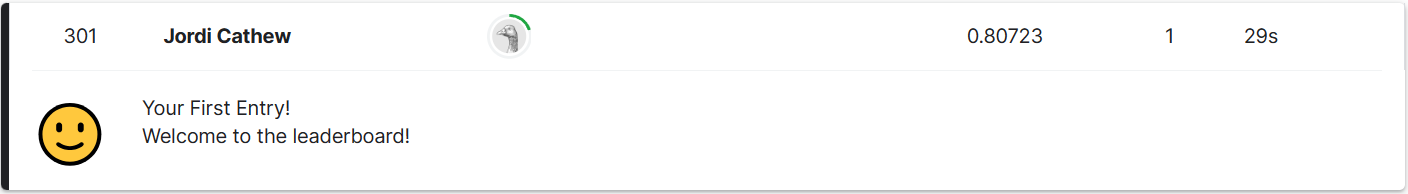

# Exercise 5: Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

In [30]:
val_preds = model_kaggle.predict(val_sentences)
val_preds = tf.cast(tf.squeeze(tf.round(val_preds)), dtype=tf.int32)

val_preds.shape, val_labels.shape

24/24 [==============================] - 0s 16ms/step


(TensorShape([762]), (762,))

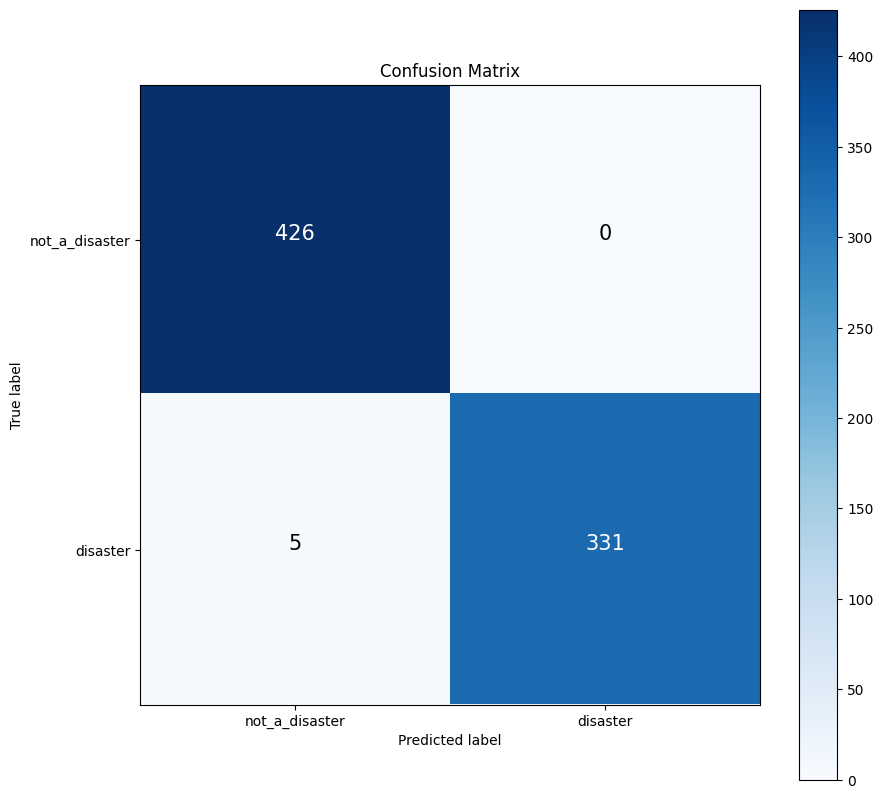

In [31]:
from helper_functions import make_confusion_matrix

make_confusion_matrix(val_labels, val_preds, ["not_a_disaster", "disaster"])